In [1]:
using ChangesOfVariables, InverseFunctions, ArraysOfArrays, Statistics
using Optimisers
using PyPlot
using Distributions
using LinearAlgebra
using Test

# using ForwardDiff
# using ReverseDiff
using FiniteDifferences

using Revise
using EuclidianNormalizingFlows

┌ Info: Precompiling FiniteDifferences [26cc04aa-876d-5657-8c51-4c34ba976000]
└ @ Base loading.jl:1423


In [2]:
# Compare transformation results & gradients using ForwardDiff and and handwritten pullbacks.

function run_test_suite(; nrepetitions = 20,
        ndims = 8,
        nparams = 5,
        nsmpls = 15,
        dist = Uniform(-3, 3),
    )
    
    for i in 1:nrepetitions
        
        algo = central_fdm(5, 1)
        rtol = 0.001

        w = rand(dist, ndims, nparams)
        h = rand(dist, ndims, nparams)
        d = rand(dist, ndims, nparams-1)
        x = rand(Normal(0, 5), ndims, nsmpls)
        
        try 
            
            trafo_frwd = RationalQuadSpline(w,h,d)
            trafo_bcwd = RationalQuadSplineInv(w,h,d)

            x_fwd, jac_frwd = EuclidianNormalizingFlows.with_logabsdet_jacobian(trafo_frwd, x)
            x_bcwd, jac_bcwd = EuclidianNormalizingFlows.with_logabsdet_jacobian(trafo_bcwd, x_fwd) 

            @test x_bcwd ≈ x
            @test jac_frwd ≈ -jac_bcwd

            for j in 1:size(x, 2)
                xrun = x[:,j]
                autodiff_jac = FiniteDifferences.jacobian(algo, xtmp -> trafo_frwd(reshape(xtmp, ndims,1)), xrun )[1]
                @test isapprox.(log(abs(det(autodiff_jac))), jac_frwd[1,j], rtol = rtol)
                @test isapprox.(log(abs(det(autodiff_jac))), -jac_bcwd[1, j], rtol = rtol)
            end

            neg_ll, gradvals = EuclidianNormalizingFlows.mvnormal_negll_trafograd(trafo_frwd, x)

            a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(par,h,d), x), w)[1]
            @test isapprox(a_run, gradvals.widths, rtol = rtol)

            a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(w,par,d), x), h)[1]
            @test isapprox(a_run, gradvals.heights, rtol = rtol)

            a_run = FiniteDifferences.grad(algo, par -> EuclidianNormalizingFlows.mvnormal_negll_trafo(RationalQuadSpline(w,h,par), x), d)[1]
            @test isapprox(a_run, gradvals.derivatives, rtol = rtol)

        catch 
            print("Test error. Parameters: \n")
            @show w, h, d, x
        end
        
    end
end

run_test_suite()

# 2D fit: 

In [27]:
nparams = 20
nsmpls = 6000
ndims = 2
K = nparams

dist = Uniform(-1, 1)

trafo_truth = RationalQuadSplineInv(rand(dist, ndims, nparams),rand(dist, ndims, nparams),rand(dist, ndims, nparams-1))

y = rand(Normal(0, 1), ndims, nsmpls)
x = trafo_truth(y);

In [28]:
@test x ≈ RationalQuadSpline(trafo_truth.widths,trafo_truth.heights,trafo_truth.derivatives)(RationalQuadSplineInv(trafo_truth.widths,trafo_truth.heights,trafo_truth.derivatives)(x))

Test Passed
  Expression: x ≈ (RationalQuadSpline(trafo_truth.widths, trafo_truth.heights, trafo_truth.derivatives))((RationalQuadSplineInv(trafo_truth.widths, trafo_truth.heights, trafo_truth.derivatives))(x))
   Evaluated: [0.44290029689381344 0.2529101069106836 … 2.125790489646491 1.4476808233007292; 2.205804855805796 -2.4742003459737507 … -0.7973877497033033 0.6945052691377103] ≈ [0.44290029689381366 0.2529101069106836 … 2.125790489646491 1.4476808233007292; 2.2058048558057965 -2.4742003459737507 … -0.7973877497033033 0.6945052691377103]

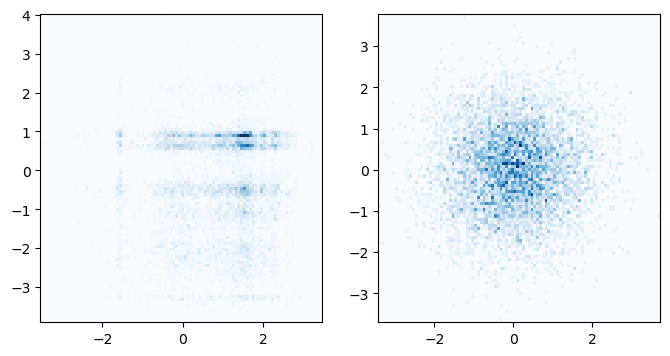

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-3.416439571571506, -3.345068778824592, -3.273697986077678, -3.2023271933307638, -3.13095640058385, -3.0595856078369357, -2.9882148150900214, -2.9168440223431076, -2.8454732295961933, -2.7741024368492795  …  3.0783025683976772, 3.1496733611445915, 3.221044153891506, 3.292414946638419, 3.3637857393853334, 3.4351565321322477, 3.506527324879162, 3.5778981176260762, 3.6492689103729896, 3.720639703119905], [-3.700850700188577, -3.626093706707093, -3.5513367132256093, -3.4765797197441253, -3.4018227262626413, -3.3270657327811572, -3.2523087392996732, -3.1775517458181897, -3.1027947523367057, -3.0280377588552216  …  3.102035706626458, 3.1767927001079417, 3.251549693589426, 3.3263066870709097, 3.401063680552394, 3.4758206740338777, 3.5505776675153613, 3.6253346609968458, 3.7000916544783293, 3.7748486479598142], PyObject <matplotlib.collections.QuadMesh object at 0x7fdc35f0fca0>)

In [29]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(y[1,:], y[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

In [30]:
# initial_trafo = 
#     EuclidianNormalizingFlows.JohnsonTrafo([10.0, 11.0], [3.5, 3.6], [10.0, 11.0], [1.0, 1.1]) ∘
#     EuclidianNormalizingFlows.ScaleShiftTrafo(ones(ndims), zeros(ndims)) ∘  
#     RationalQuadSpline(ones(ndims, nparams), ones(ndims, nparams), ones(ndims, nparams-1))

# initial_trafo =  ScaleShiftTrafo(ones(ndims), zeros(ndims))

initial_trafo =  RationalQuadSpline(ones(ndims, nparams), ones(ndims, nparams), ones(ndims, nparams-1))

optimizer = ADAGrad()
smpls = nestedview(x)
nbatches = 20
nepochs = 10 

r = EuclidianNormalizingFlows.optimize_whitening(smpls, initial_trafo, optimizer, nbatches = nbatches, nepochs = nepochs)

(result = RationalQuadSpline([1.0377050839207056 1.0377050839207056 … 0.9708341436641247 0.9708341436641247; 0.9225314448122984 0.9225314448122984 … 1.011297911940384 1.0113795361462747], [0.869164616563421 0.869164616563421 … 1.0611902701923481 1.0611902701923481; 1.365580229806404 1.365580229806404 … 0.9710684075821788 0.9705410467821972], [1.0 0.3779867349329684 … 1.0 1.0; 1.0 0.9188123258548244 … 1.2507692227639444 0.9391240438672502]), optimizer_state = (widths = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [0.651787 0.651787 … 1.09717 1.09717; 2.70821 2.70821 … 3.75528 3.75538]), heights = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [0.0802865 0.0802865 … 0.179049 0.179049; 0.165843 0.165843 … 0.082182 0.0820529]), derivatives = Leaf(AdaGrad{Float32}(0.1, 1.19209f-7), [1.19209e-7 2.12633e-6 … 1.19209e-7 1.19209e-7; 1.19209e-7 6.53392e-7 … 3.12789e-5 1.49854e-7])), negll_history = [3.708847725255495, 3.34663345873672, 3.0947498602968633, 2.987098346748221, 2.9623363740187134, 2.91104309402

In [31]:
yhat = r.result(x)

2×6000 Matrix{Float64}:
 -0.485866  -0.592731  1.81821    …   0.195411   1.25523   0.290796
  2.36265   -1.43247   0.0350176     -1.8966    -0.460782  0.591345

In [32]:
@show mean(yhat, dims=2)
@show std(yhat, dims=2)

mean(yhat, dims = 2) = [-0.016071849926969424; 0.0418449840218659;;]
std(yhat, dims = 2) = [0.9930823720451596; 1.0110711013361904;;]


2×1 Matrix{Float64}:
 0.9930823720451596
 1.0110711013361904

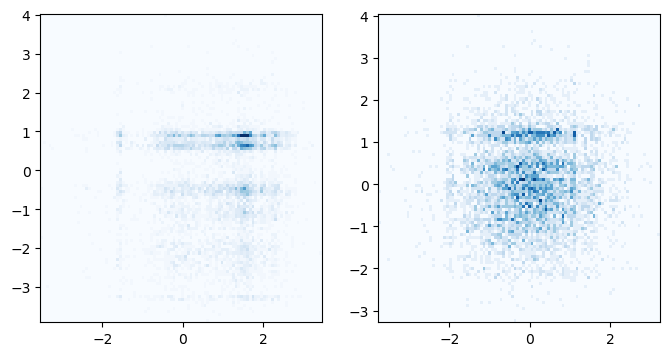

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-3.7647826448554715, -3.694637475929975, -3.624492307004479, -3.554347138078983, -3.484201969153487, -3.4140568002279905, -3.343911631302494, -3.273766462376998, -3.203621293451502, -3.1334761245260054  …  2.6184277273646837, 2.6885728962901805, 2.7587180652156764, 2.8288632341411724, 2.899008403066669, 2.969153571992165, 3.039298740917661, 3.109443909843158, 3.179589078768654, 3.24973424769415], [-3.2788926982239284, -3.205712796641142, -3.1325328950583557, -3.059352993475569, -2.9861730918927827, -2.9129931903099964, -2.83981328872721, -2.7666333871444238, -2.693453485561637, -2.6202735839788507  …  3.3804783458096344, 3.453658247392421, 3.526838148975208, 3.6000180505579937, 3.6731979521407805, 3.7463778537235664, 3.819557755306353, 3.89273765688914, 3.9659175584719257, 4.0390974600547125], PyObject <matplotlib.collections.QuadMesh object at 0x7fdc35dec0d0>)

In [33]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(yhat[1,:], yhat[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

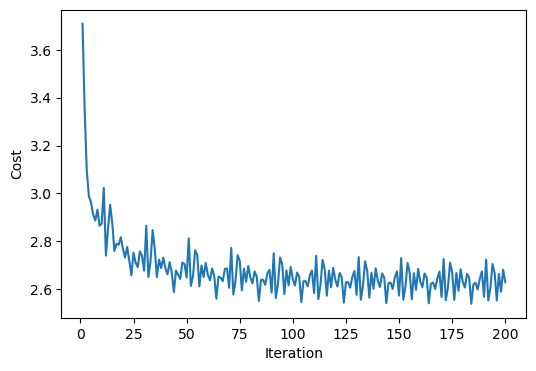

PyObject Text(0.5, 24.0, 'Iteration')

In [34]:
fig, ax = plt.subplots(1,1,  figsize=(6,4))

ax.plot(1:length(r.negll_history), r.negll_history)
ax.set_ylabel("Cost")
ax.set_xlabel("Iteration")

# 20D fit: 

In [35]:
nparams = 20 # 1180 parameters in total
nsmpls = 6000
ndims = 20
K = nparams
dist = Uniform(-1, 1)

y = rand(Normal(0, 1), ndims, nsmpls);

In [36]:
bwd_true =
#     EuclidianNormalizingFlows.ScaleShiftTrafo([1., 0.4], [2.5, -1.2]) ∘
#     EuclidianNormalizingFlows.HouseholderTrafo([1.0, 0.3]) ∘
#     EuclidianNormalizingFlows.CenterStretch([1.0, 0.1], [2.0, 2.1], [1.0, 1.1]) ∘
    RationalQuadSplineInv(rand(dist, ndims, nparams),rand(dist, ndims, nparams),rand(dist, ndims, nparams-1))

x = bwd_true(y)

20×6000 Matrix{Float64}:
 -1.30588     0.998496    0.781662   …   1.31786    0.260125  -0.150096
  1.33363     1.08728     1.28457       -0.258022  -0.326745   1.72248
 -1.59677    -0.594071    2.06232       -1.30253   -0.363713  -3.53628
  1.85796    -0.294692    2.14383        1.81359   -1.33234    0.0615947
  0.598939    0.706313    1.44913        0.584724  -1.14609    0.611498
  0.745262    2.70917     1.79398    …   1.36247    2.19812    1.97412
  1.846      -0.444491    0.7439         0.652693   0.640181   0.697022
 -0.601597    0.285765    1.2944        -0.933709   1.26542    1.80639
  1.71208     0.534608    0.471274       0.311128   1.36089    1.26669
  0.158282   -0.0609179   0.489965       1.35093    0.230096   2.03071
  0.680326    1.69261    -0.0717925  …   0.912578   0.28394   -0.0836369
 -1.82243    -1.31484    -2.22972       -0.30782    0.183995  -1.80117
 -0.506911    1.32423     1.65679        1.68978    1.65742    0.568096
  1.91076     1.77886    -0.525097       1.7

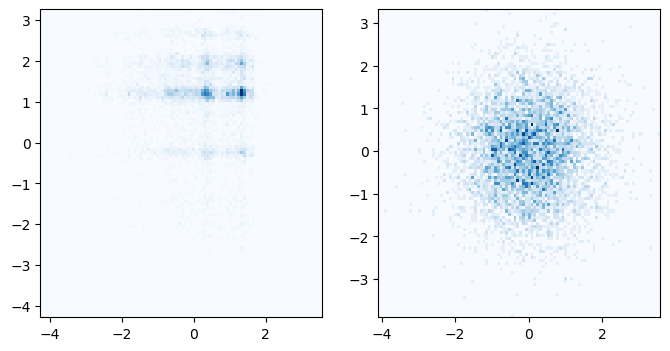

In [37]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(y[1,:], y[2,:], 100, cmap="Blues");
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

In [43]:
initial_trafo = 
    RationalQuadSpline(ones(ndims, 40), ones(ndims, 40), ones(ndims, 40-1)) #∘
#     EuclidianNormalizingFlows.ScaleShiftTrafo([1., 1], [2., 2]) 

optimizer = ADAGrad(0.1)
smpls = nestedview(x)
nbatches = 50
nepochs = 10 

r = EuclidianNormalizingFlows.optimize_whitening(smpls, initial_trafo, optimizer, nbatches = nbatches, nepochs = nepochs);

In [44]:
yhat = r.result(x);

In [45]:
@show mean(yhat, dims=2)
@show std(yhat, dims=2);

mean(yhat, dims = 2) = [0.030072441077398343; -0.05203513455401926; 0.006276760382826911; 0.028944952496292628; 0.04232987588035034; 0.021930475819773594; 0.040412123801649574; -0.010813860107463545; 0.013378544932872256; 0.08113702150762377; 0.03489952575314162; 0.02724564609769741; -0.004210656427830194; -0.04568895937994758; 0.005945170443058893; 0.014434775430345765; 0.035482806290930126; -0.0072325662354312; -0.03190845464334848; -0.07074477541223129;;]
std(yhat, dims = 2) = [1.0046134612403785; 0.9876108744732908; 0.9984566078837712; 1.016652555444825; 1.0174185733216774; 0.9918839793926534; 1.0208328481306268; 1.0016720263587342; 1.0169189858659264; 1.0164881683491103; 1.000954293062885; 0.9918889663672513; 0.9887356916683551; 0.9836764734767203; 1.0070029356305128; 1.0126458030578172; 1.0006100342072852; 1.009945031938527; 1.005815223271988; 0.9991213941791804;;]


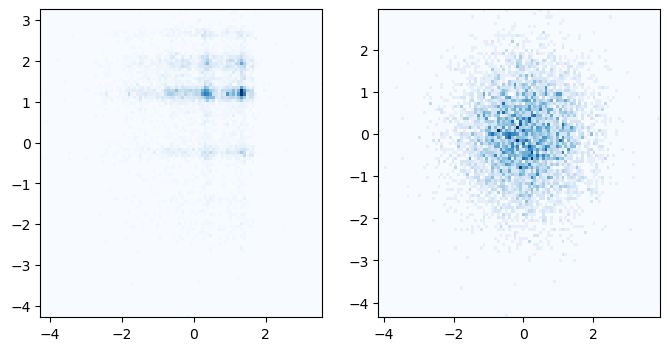

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [-4.156626973184522, -4.075849612305486, -3.99507225142645, -3.9142948905474144, -3.8335175296683786, -3.7527401687893427, -3.671962807910307, -3.591185447031271, -3.5104080861522355, -3.4296307252731997  …  3.1941128668077345, 3.27489022768677, 3.3556675885658063, 3.4364449494448417, 3.517222310323878, 3.5979996712029134, 3.678777032081949, 3.759554392960985, 3.8403317538400206, 3.921109114719056], [-4.349473811859853, -4.276350885133498, -4.203227958407142, -4.130105031680787, -4.056982104954432, -3.9838591782280766, -3.9107362515017217, -3.8376133247753663, -3.764490398049011, -3.691367471322656  …  2.3047125202384704, 2.377835446964826, 2.450958373691181, 2.524081300417536, 2.5972042271438918, 2.6703271538702467, 2.7434500805966016, 2.8165730073229573, 2.8896959340493122, 2.962818860775667], PyObject <matplotlib.collections.QuadMesh object at 0x7fdc3746feb0>)

In [46]:
fig, ax = plt.subplots(1,2,  figsize=(8,4))

ax[1].hist2d(x[1,:], x[2,:], 100, cmap="Blues")
# ax[1].scatter(x[1,:], x[2,:], s=0.1, alpha=0.2, color="C0")

ax[2].hist2d(yhat[1,:], yhat[2,:], 100, cmap="Blues")
# ax[2].scatter(y[1,:], y[2,:], s=0.1, alpha=0.5, color="C0")

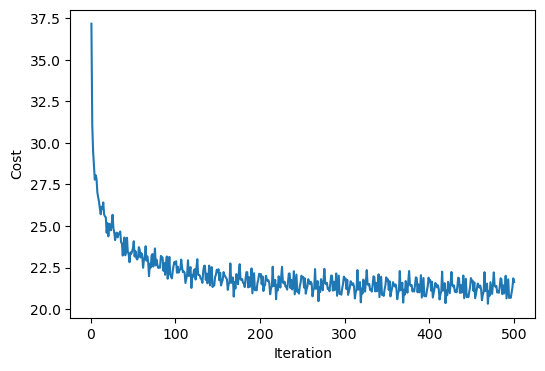

PyObject Text(0.5, 24.0, 'Iteration')

In [47]:
fig, ax = plt.subplots(1,1,  figsize=(6,4))

ax.plot(1:length(r.negll_history), r.negll_history)
ax.set_ylabel("Cost")
ax.set_xlabel("Iteration")